<a href="https://colab.research.google.com/github/9-coding/PyTorch/blob/main/Lecture-AI_programming/week13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Library

In [1]:
import torch
import torchvision
import time
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.models import ResNet50_Weights
from tqdm.auto import tqdm

# Trainset과 Testset 생성.

1. cifar10 의 10가지 종류

In [2]:
class_names = ['airplane', 'car',
               'bird', 'cat',
               'deer', 'dog',
               'frog', 'horse',
               'ship', 'truck']

2. cifar10을 다운로드
3. train과 test를 위한 Dataset 생성.
  * `torch.tensor`로 변환.
  * `standaradization`을 수행.

In [3]:
data_path = os.path.join('dataset')

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize(
        #     (0.4915, 0.4823, 0.4468),
        #     (0.2470, 0.2435, 0.2616)
        # )
    ]
)

cifar10_train = datasets.CIFAR10(
    data_path,
    train = True,
    download = True,
    transform = transform,
)

cifar10_test = datasets.CIFAR10(
    data_path,
    train = False,
    download = True,
    transform = transform,
)

100%|██████████| 170498071/170498071 [00:05<00:00, 29846929.93it/s]


Extracting dataset/cifar-10-python.tar.gz to dataset
Files already downloaded and verified


In [4]:
print(f'{type(transform)     = }')
print(f'{type(cifar10_train) = }')
print(f'{type(cifar10_test)  = }')

type(transform)     = <class 'torchvision.transforms.transforms.Compose'>
type(cifar10_train) = <class 'torchvision.datasets.cifar.CIFAR10'>
type(cifar10_test)  = <class 'torchvision.datasets.cifar.CIFAR10'>


In [5]:
x_train, x_val, y_train, y_val = train_test_split(
    cifar10_train.data,
    cifar10_train.targets,
    test_size=0.2,
    random_state=42
)

print(f'{type(x_train) = }')
print(f'{type(x_val) = }')

print(f'{x_train.shape = }')
print(f'{x_val.shape = }')

type(x_train) = <class 'numpy.ndarray'>
type(x_val) = <class 'numpy.ndarray'>
x_train.shape = (40000, 32, 32, 3)
x_val.shape = (10000, 32, 32, 3)


In [6]:
# StandardScaler를 사용하여 데이터를 표준화합니다.

# scaler = StandardScaler()
scaler = MinMaxScaler()
N_train, C, H, W = x_train.shape
N_val = x_val.shape[0]

train_data = x_train.reshape((N_train, -1))
val_data = x_val.reshape((N_val, -1))

train_data = scaler.fit_transform(train_data)
val_data = scaler.transform(val_data)

x_train = train_data.reshape((N_train, C, H, W))
x_val = val_data.reshape((N_val, C, H, W))

In [ ]:
train_set = data.TensorDataset(torch.tensor(x_train).permute(0,3,1,2).float(),
                               torch.tensor(y_train).long())
validation_set  = data.TensorDataset(torch.tensor(x_val).permute(0,3,1,2).float(),
                                     torch.tensor(y_val).long())

print(f'{type(train_set) = }')
print(f'{type(validation_set) = }')

In [7]:
batch_size = 32
n_worker = 0
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = n_worker,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size = batch_size,
    shuffle = False,
    num_workers = n_worker,
)

test_loader = torch.utils.data.DataLoader(
    cifar10_test,
    batch_size = batch_size,
    shuffle = False,
    num_workers = n_worker,
)

In [8]:
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


type(grid_img)=<class 'torch.Tensor'>
max_val.item()=1.0
min_val.item()=0.0


(-0.5, 273.5, 137.5, -0.5)

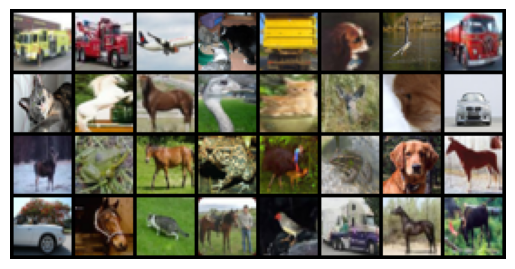

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

grid_img = torchvision.utils.make_grid(images)
max_val = torch.max(grid_img)
min_val = torch.min(grid_img)
print(f'{type(grid_img)=}\n{max_val.item()=}\n{min_val.item()=}')

normalized_grid_img = (grid_img - min_val) / (max_val - min_val)
plt.imshow(np.transpose(normalized_grid_img, (1,2,0)))
plt.axis('off')

type(grid_img)=<class 'torch.Tensor'>
max_val.item()=1.0
min_val.item()=0.0


(-0.5, 273.5, 137.5, -0.5)

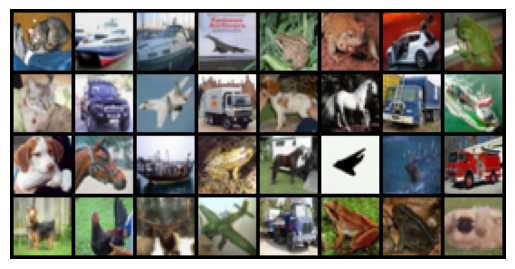

In [10]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

grid_img = torchvision.utils.make_grid(images)
max_val = torch.max(grid_img)
min_val = torch.min(grid_img)
print(f'{type(grid_img)=}\n{max_val.item()=}\n{min_val.item()=}')

normalized_grid_img = (grid_img - min_val) / (max_val - min_val)
plt.imshow(np.transpose(normalized_grid_img, (1,2,0)))
plt.axis('off')

# Train Loop

In [11]:
def train_loop (
    n_epoch,
    train_loader, val_loader,
    model, optimizer, loss_fnc,
    device = 'cpu',):

  log_hist = torch.zeros([0,3]).to(device)
  tmp = torch.empty((1, 3), device=log_hist.device)

  model = model.to(device)
  start_time = time.time()  # iteration 시작 시간 기록
  best_loss_val = float('inf')
  best_model_wts = None

  for epoch in tqdm(range(n_epoch)):
    # print(f'\r{epoch:6>}', end='')

    model.train()
    for x_tensor, y_tensor in train_loader:

      x_tensor = x_tensor.to(device)
      y_tensor = y_tensor.to(device)
    #   x_tensor.to(device)
    #   y_tensor.to(device)

      y_pred = model(x_tensor)
      # print(y_tensor.shape)
      loss_train = loss_fnc(y_pred,y_tensor)

      if torch.isinf(loss_train):
        print(f'Error: loss is infinity!')
        break

      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()

    with torch.no_grad():
      model.eval()
      for x_tensor, y_tensor in val_loader:
        x_tensor = x_tensor.to(device)
        y_tensor = y_tensor.to(device)
        pred = model(x_tensor)
        loss_val = loss_fnc(pred, y_tensor)

    if loss_val < best_loss_val:
        best_loss_val = loss_val
        print(f'best model wts at {epoch} : {loss_val = }')
        best_model_wts = model.state_dict()

    if epoch % 5 == 0:

      # tmp = torch.tensor([epoch, loss_train.item(), loss_val.item()]).to(log_hist.device)
      tmp[0, 0] = epoch
      tmp[0, 1] = loss_train.item()
      tmp[0, 2] = loss_val.item()

      # print(tmp)
      log_hist = torch.concat( (log_hist, tmp.reshape(1,-1)), dim=0 )
      end_time = time.time()  # iteration 종료 시간 기록
      iteration_time = (end_time - start_time)  # 소요 시간을 초 단위로 계산
      print(f'{epoch+1}/{n_epoch} Epoch [{iteration_time:.2f}s]/ loss {loss_train.item():.4f} / val_loss {loss_val.item():.4f}')

      start_time = time.time()  # iteration 시작 시간 기록

    if epoch == n_epoch-1:
      tmp[0, 0] = epoch
      tmp[0, 1] = loss_train.item()
      tmp[0, 2] = loss_val.item()
      end_time = time.time()  # iteration 종료 시간 기록
      iteration_time = (end_time - start_time)  # 소요 시간을 초 단위로 계산
      print(f'{epoch+1}/{n_epoch} Epoch [{iteration_time:.2f}s] / loss {loss_train.item():.4f} / val_loss {loss_val.item():.4f}')

  return best_model_wts,log_hist

# Model

In [12]:
# ResNet50_Weights의 모든 옵션 나열
print(list(ResNet50_Weights))

[ResNet50_Weights.IMAGENET1K_V1, ResNet50_Weights.IMAGENET1K_V2]


In [13]:
def get_resnet50():
    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.layer3.parameters():
        param.requires_grad = True

    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)  # CIFAR-10 분류를 위해 마지막의 fully connected layer 수정
    return model

net = get_resnet50()
print(net)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 98.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

In [14]:
# device 설정.
device = (
      "cuda" if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu"
  )
print(f"{device=}")

device='cuda'


In [15]:
# number of epochs
n_epoch = 50
# learning ratio
lr = 1e-4

# loss function 설정
loss_fnc  = nn.CrossEntropyLoss()

# 모델 생성 및 초기화
# model = Net()
model = get_resnet50()

# optimizer 생성 및 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=lr) # recommanded

# 경사하강법(SGD) 옵티마이저로, 모델 파라미터의 업데이트를 수행한다.
# net.parameters() : 모델의 학습 가능한 파라미터들을 반환.
# lr : learning rate(학습률)을 나타낸다.
# momentum : 관성을 나타내며, 학습의 안정성과 수렴 속도를 높이는데 도움을 준다.
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

best_model_wts, h = train_loop (
    n_epoch,
    train_loader, valid_loader,
    model, optimizer, loss_fnc,
    device = device)


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


best model wts at 0 : loss_val = tensor(0.5367, device='cuda:0')
1/50 Epoch [42.30s]/ loss 0.9344 / val_loss 0.5367
best model wts at 2 : loss_val = tensor(0.4073, device='cuda:0')
6/50 Epoch [218.68s]/ loss 0.0886 / val_loss 0.6779
11/50 Epoch [205.49s]/ loss 0.0140 / val_loss 1.2372
16/50 Epoch [209.28s]/ loss 0.1848 / val_loss 2.0158
21/50 Epoch [196.82s]/ loss 0.0111 / val_loss 1.2175
26/50 Epoch [196.27s]/ loss 0.0211 / val_loss 1.3599
31/50 Epoch [198.46s]/ loss 0.0011 / val_loss 0.8614
36/50 Epoch [196.22s]/ loss 0.0010 / val_loss 1.3791
41/50 Epoch [196.62s]/ loss 0.0008 / val_loss 0.9152
46/50 Epoch [195.93s]/ loss 0.0006 / val_loss 1.2639
50/50 Epoch [156.28s] / loss 0.0218 / val_loss 0.9889


# Laerning Curve

(10, 3)


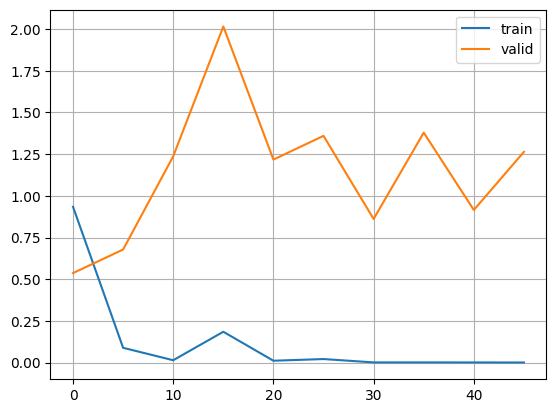

In [16]:
h = h.cpu()
h0 = h.detach().numpy()
print(h0.shape)
plt.plot(h0[:,0], h0[:,1], label='train')
plt.plot(h0[:,0], h0[:,2], label='valid')
plt.legend()
plt.grid()
plt.show()

In [17]:
f_m = model.cpu()
print(f_m.load_state_dict(best_model_wts))
f_m.eval()
with torch.no_grad():
  is_first = True
  for x_tensor, y_tensor in test_loader:
    x_tensor = x_tensor.cpu()
    y_tensor = y_tensor.cpu()
    pred_prob = f_m(x_tensor)
    pred = torch.argmax(pred_prob, dim=-1) # class 수 만큼 나오므로 가장 큰 확률의 index를 얻어야함.

    # print(y_tensor.numpy().shape)
    if is_first:
      test_pred = pred.numpy().copy()
      test_label = y_tensor.numpy().copy()
      is_first = False
    else:
      test_label = np.concatenate((test_label, y_tensor.numpy()), axis=0)
      test_pred = np.concatenate((test_pred, pred.numpy()), axis=0)

print(test_label.shape, test_label.dtype)
print(test_pred.shape, test_pred.dtype)

<All keys matched successfully>
(10000,) int64
(10000,) int64


In [18]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    fbeta_score,
)
pred = test_pred
label = test_label

print('Confusion Matrix\n',
      str(confusion_matrix(label,pred))
      )
print(f'Precision           :{np.round(precision_score(label,pred,average=None),2)}')
print(f'Precision (macro)   :{np.round(precision_score(label,pred,average="macro"),2)}')
print(f'Precision (micro)   :{np.round(precision_score(label,pred,average="micro"),2)}')
print(f'Precision (weighted):{np.round(precision_score(label,pred,average="weighted"),2)}')
print(f'Recall              :{np.round(recall_score(label,pred,average=None),2)}')
print(f'Recall    (macro)   :{np.round(recall_score(label,pred,average="macro"),2)}')
print(f'Recall    (micro)   :{np.round(recall_score(label,pred,average="micro"),2)}')
print(f'Recall    (weighted):{np.round(recall_score(label,pred,average="weighted"),2)}')
print(f'F1-score            :{np.round(f1_score(label,pred,average=None),2)}')
print(f'F1-score  (macro)   :{np.round(f1_score(label,pred,average="macro"),2)}')
print(f'F1-score  (micro)   :{np.round(f1_score(label,pred,average="micro"),2)}')
print(f'F1-score  (weighted):{np.round(f1_score(label,pred,average="weighted"),2)}')
print(f'F2-score            :{np.round(fbeta_score(label,pred,beta=2,average=None),2)}')
print(f'F2-score  (macro)   :{np.round(fbeta_score(label,pred,beta=2,average="macro"),2)}')
print(f'F2-score  (micro)   :{np.round(fbeta_score(label,pred,beta=2,average="micro"),2)}')
print(f'F2-score  (weighted):{np.round(fbeta_score(label,pred,beta=2,average="weighted"),2)}')



Confusion Matrix
 [[828  13  35  11  14   3   7  13  48  28]
 [  5 876   5   4   3   2   7   8  29  61]
 [ 27   2 816  27  39  33  21  29   3   3]
 [ 11   3  60 620  41 173  33  38   8  13]
 [  8   3  85  33 741  30  31  61   5   3]
 [  9   2  36 104  25 757  19  42   1   5]
 [  3   2  42  34  12  18 874   7   4   4]
 [  7   1  23  17  30  24   1 884   3  10]
 [ 28  17  11   8   4   2   1   4 915  10]
 [ 13  51   7   7   4   2   1   8  16 891]]
Precision           :[0.88 0.9  0.73 0.72 0.81 0.73 0.88 0.81 0.89 0.87]
Precision (macro)   :0.82
Precision (micro)   :0.82
Precision (weighted):0.82
Recall              :[0.83 0.88 0.82 0.62 0.74 0.76 0.87 0.88 0.92 0.89]
Recall    (macro)   :0.82
Recall    (micro)   :0.82
Recall    (weighted):0.82
F1-score            :[0.85 0.89 0.77 0.66 0.77 0.74 0.88 0.84 0.9  0.88]
F1-score  (macro)   :0.82
F1-score  (micro)   :0.82
F1-score  (weighted):0.82
F2-score            :[0.84 0.88 0.8  0.64 0.75 0.75 0.87 0.87 0.91 0.89]
F2-score  (macro)   :0.82